In [4]:
# 1. IMPORTS & SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import kruskal, f_oneway, chi2_contingency

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [5]:
# 2. CARREGANDO OS DADOS

df = pd.read_csv('..\data\CreditCardCustomerData.csv')

print(f"Shape: {df.shape[0]} linhas × {df.shape[1]} colunas\n")
print("Colunas:")
for col in df.columns:
    print(f"   • {col} ({df[col].dtype})")

Shape: 660 linhas × 7 colunas

Colunas:
   • Sl_No (int64)
   • Customer Key (int64)
   • Avg_Credit_Limit (int64)
   • Total_Credit_Cards (int64)
   • Total_visits_bank (int64)
   • Total_visits_online (int64)
   • Total_calls_made (int64)


In [6]:
# Primeiras linhas
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [7]:
# Estatísticas descritivas
df.describe().T.round(2).rename(columns={'50%': 'median'}).style.background_gradient(cmap='Blues', subset=['mean', 'median', 'std'])

,count,mean,std,min,25%,median,75%,max
Sl_No,660.000000,330.500000,190.670000,1.000000,165.750000,330.500000,495.250000,660.000000
Customer Key,660.000000,55141.440000,25627.770000,11265.000000,33825.250000,53874.500000,77202.500000,99843.000000
Avg_Credit_Limit,660.000000,34574.240000,37625.490000,3000.000000,10000.000000,18000.000000,48000.000000,200000.000000
Total_Credit_Cards,660.000000,4.710000,2.170000,1.000000,3.000000,5.000000,6.000000,10.000000
Total_visits_bank,660.000000,2.400000,1.630000,0.000000,1.000000,2.000000,4.000000,5.000000
Total_visits_online,660.000000,2.610000,2.940000,0.000000,1.000000,2.000000,4.000000,15.000000
Total_calls_made,660.000000,3.580000,2.870000,0.000000,1.000000,3.000000,5.000000,10.000000


660 clientes analisados

LIMITE DE CRÉDITO: Média R$ 34,5k, mas metade tem até R$ 18k (desigualdade). Varia de R$ 3k a R$ 200k.

CARTÕES: Média de 4,7 cartões por cliente (entre 1 e 10).

ATENDIMENTO:

Agência: 2,4 visitas (média)

Online: 2,6 acessos (alguns até 15x)

Telefone: 3,6 ligações

Clientes com limite muito alto puxam a média pra cima; acesso online é o canal mais variável

In [8]:
# 3. PRÉ-PROCESSAMENTO

# 3.1 Nulos
nulls = df.isnull().sum()
nulls_pct = (nulls / len(df) * 100).round(2)

null_df = pd.DataFrame({
    'Nulos': nulls,
    '% do Total': nulls_pct
}).sort_values('Nulos', ascending=False)

print("Valores nulos por coluna:")
print(null_df[null_df['Nulos'] > 0].to_string() if null_df['Nulos'].sum() > 0 else "Nenhum valor nulo encontrado!")

Valores nulos por coluna:
Nenhum valor nulo encontrado!


In [14]:
# 3.2 Colunas irrelevantes & duplicatas

# Colunas que não entram na clusterização
cols_drop = ['Sl_No', 'Customer Key'] 

df_clean = df.drop(columns=[c for c in cols_drop if c in df.columns], errors='ignore')

# Duplicatas
dupes = df_clean.duplicated().sum()
print(f"Linhas duplicadas: {dupes}")
df_clean = df_clean.drop_duplicates()

print(f"Shape após limpeza: {df_clean.shape}")

Linhas duplicadas: 11
Shape após limpeza: (649, 5)


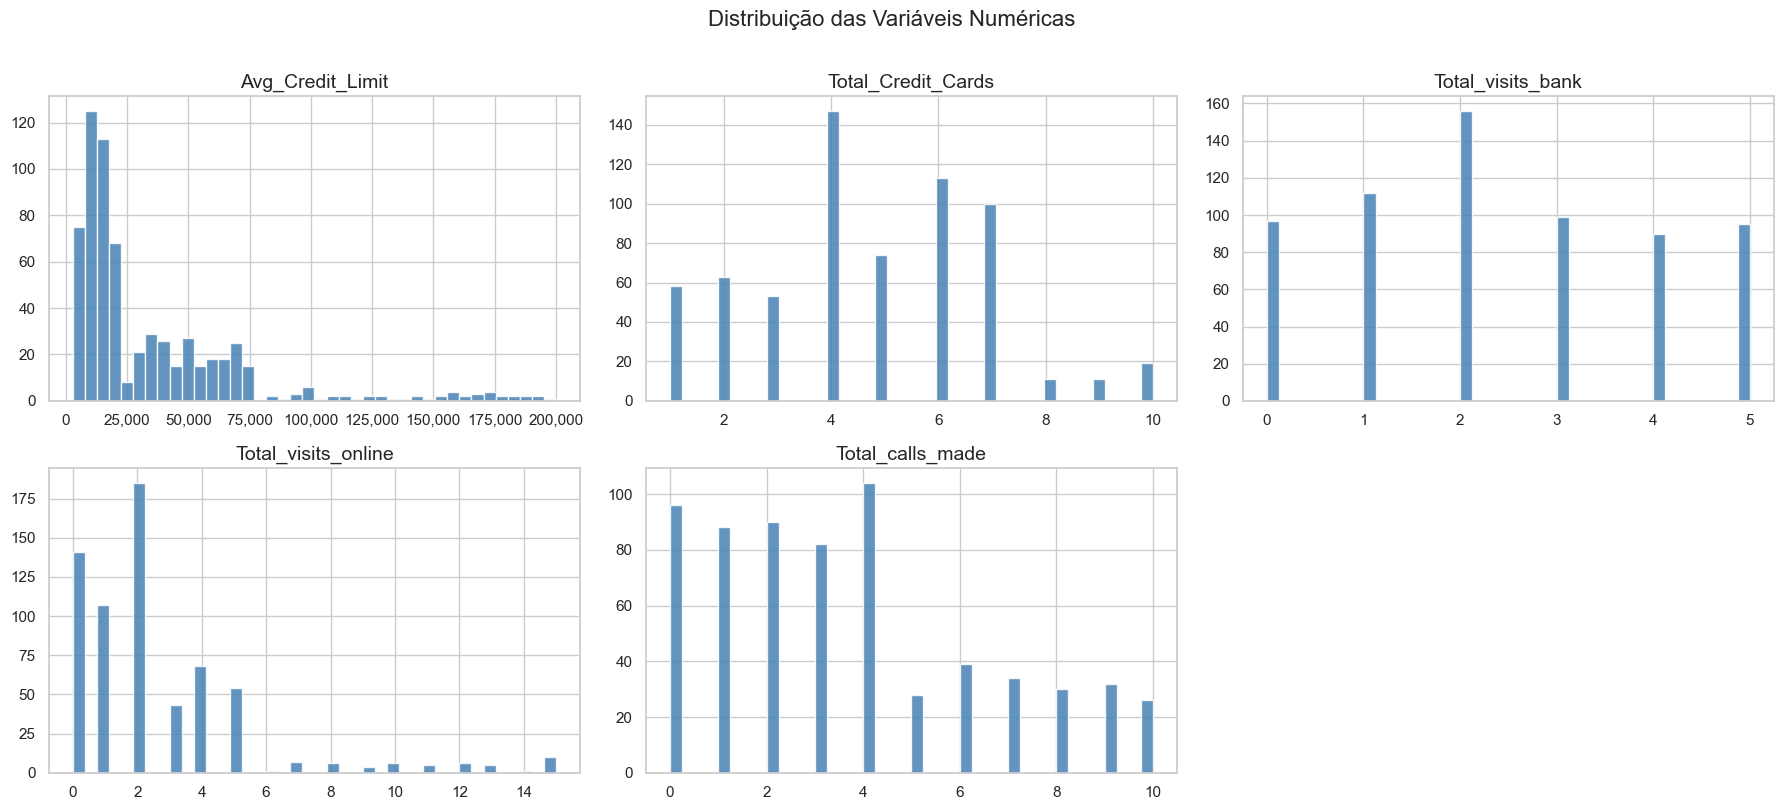

In [11]:
# 3.3 Distribuição das variáveis numéricas

num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df_clean[col].dropna(), bins=40, color='steelblue', edgecolor='white', alpha=0.85)
    axes[i].set_title(col)
    axes[i].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Esconde eixos sobrando
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribuição das Variáveis Numéricas', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

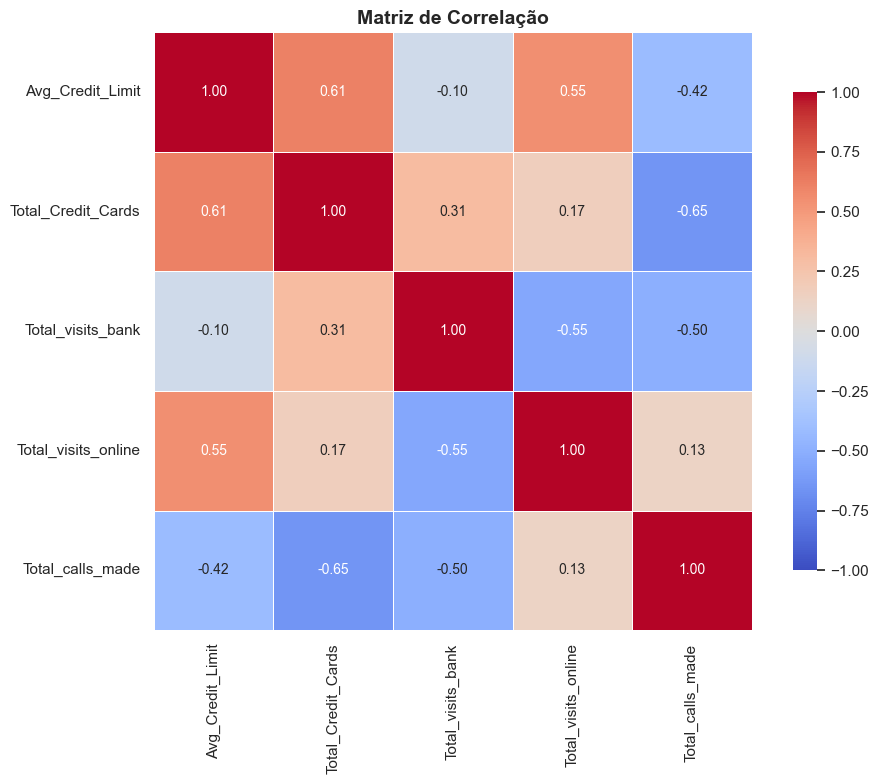

In [18]:
# 3.5 Heatmap de Correlação

plt.figure(figsize=(10, 8))


sns.heatmap(
    df_clean.corr(), 
    annot=True,
    fmt='.2f',
    cmap='coolwarm',      
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    annot_kws={'size': 10},
    cbar_kws={'shrink': 0.8}
)
plt.title('Matriz de Correlação', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

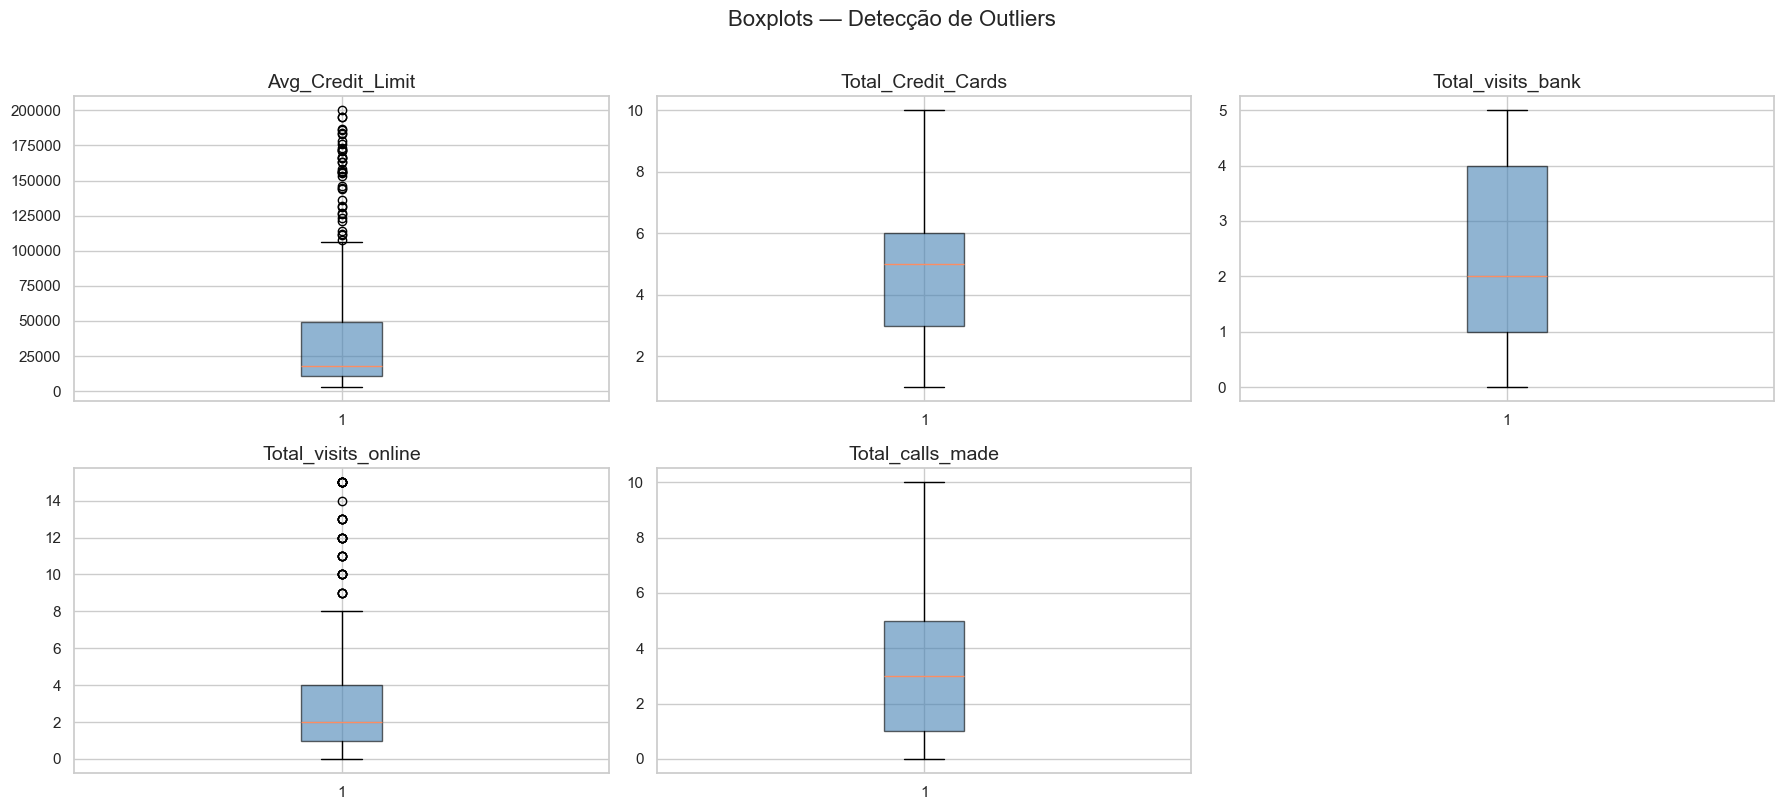

In [ ]:
# 3.6 Boxplots para detectar outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].boxplot(df_clean[col].dropna(), patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.6))
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Boxplots — Detecção de Outliers', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

In [10]:
# Quantificando outliers via IQR
print("Outliers detectados (método IQR):\n")
for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_clean[(df_clean[col] < Q1 - 1.5 * IQR) | (df_clean[col] > Q3 + 1.5 * IQR)]
    pct = round(len(outliers) / len(df_clean) * 100, 2)
    print(f"{col}: {len(outliers)} outliers ({pct}%)")

Outliers detectados (método IQR):

Avg_Credit_Limit: 38 outliers (5.86%)
Total_Credit_Cards: 0 outliers (0.0%)
Total_visits_bank: 0 outliers (0.0%)
Total_visits_online: 37 outliers (5.7%)
Total_calls_made: 0 outliers (0.0%)


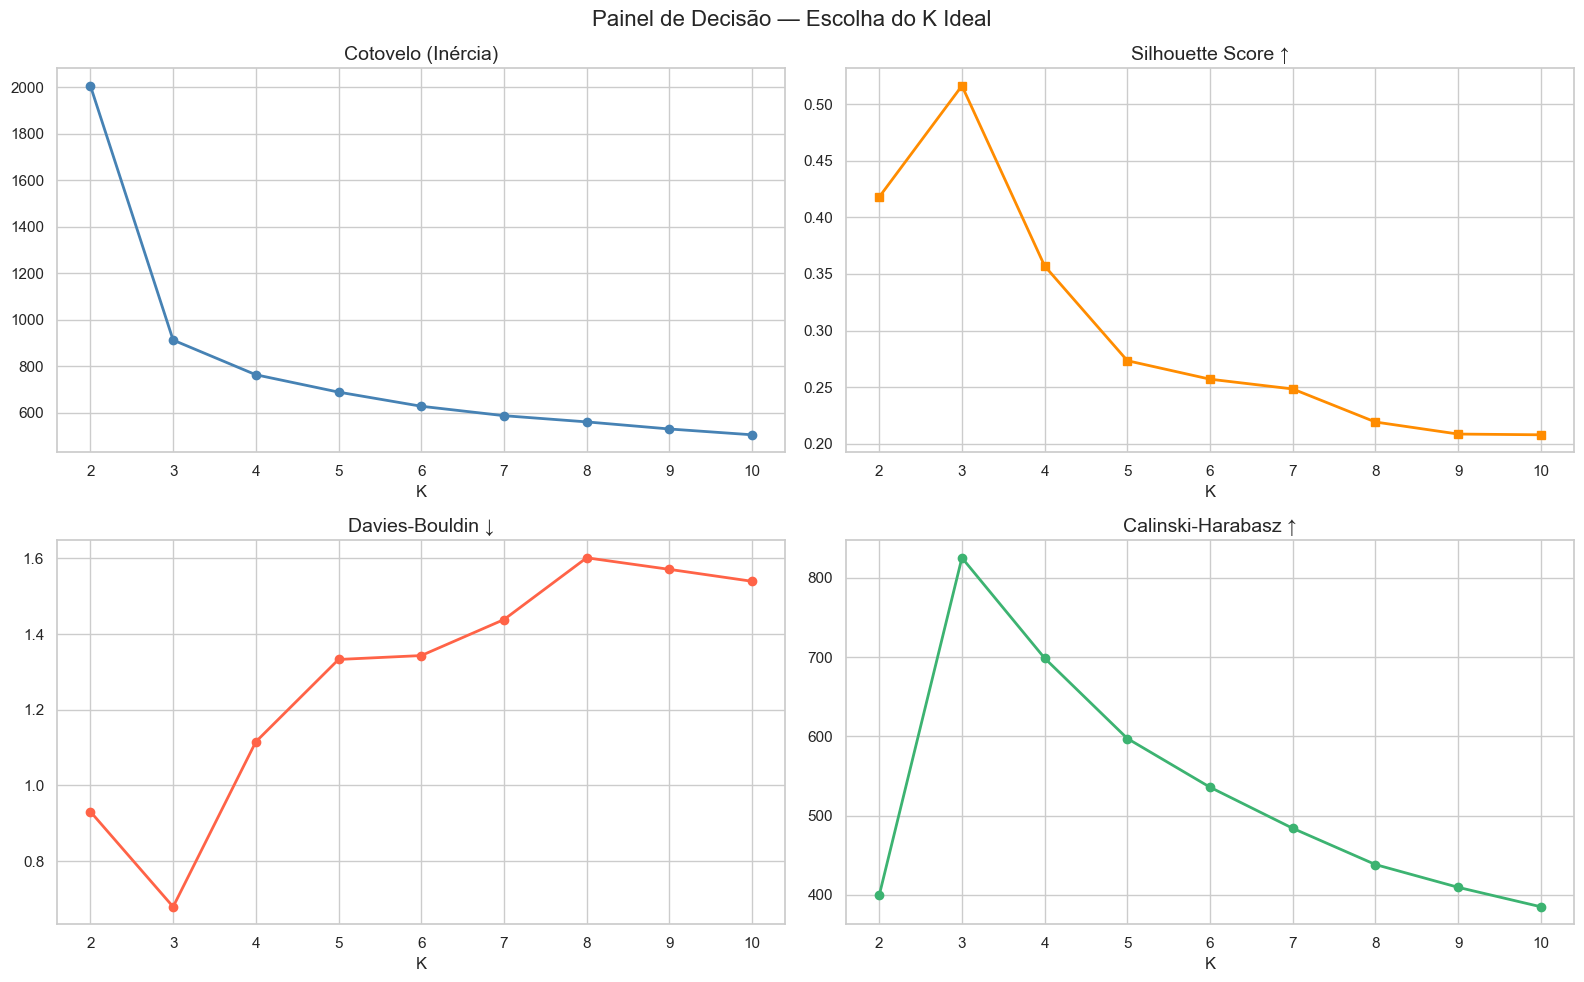

In [ ]:
# 4.0 Painel de decisão do número de clusters

# Padronizando os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean[num_cols])

# Testar diferentes K
k_range = range(2, 11)
inertias = []
silhouette_scores = []
db_scores = []
ch_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))
    db_scores.append(davies_bouldin_score(df_scaled, labels))
    ch_scores.append(calinski_harabasz_score(df_scaled, labels))

# Painel de decisão
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Cotovelo
axes[0, 0].plot(k_range, inertias, marker='o', color='steelblue', linewidth=2)
axes[0, 0].set_title('Cotovelo (Inércia)')
axes[0, 0].set_xlabel('K'); axes[0, 0].set_xticks(k_range)

# Silhueta
axes[0, 1].plot(k_range, silhouette_scores, marker='s', color='darkorange', linewidth=2)
axes[0, 1].set_title('Silhouette Score ↑')
axes[0, 1].set_xlabel('K'); axes[0, 1].set_xticks(k_range)

# Davies-Bouldin
axes[1, 0].plot(k_range, db_scores, marker='o', color='tomato', linewidth=2)
axes[1, 0].set_title('Davies-Bouldin ↓')
axes[1, 0].set_xlabel('K'); axes[1, 0].set_xticks(k_range)

# Calinski-Harabasz
axes[1, 1].plot(k_range, ch_scores, marker='o', color='mediumseagreen', linewidth=2)
axes[1, 1].set_title('Calinski-Harabasz ↑')
axes[1, 1].set_xlabel('K'); axes[1, 1].set_xticks(k_range)

plt.suptitle('Painel de Decisão — Escolha do K Ideal', fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
# 5. CLUSTERIZAÇÃO

best_k = 3

# 5.1 K-Means

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)


df_clean['Cluster_KMeans'] = labels_kmeans

print(f"\nDistribuição dos clusters:")
dist = df_clean['Cluster_KMeans'].value_counts().sort_index()
for cluster, count in dist.items():
    pct = count / len(df_clean) * 100
    print(f"   Cluster {cluster}: {count} clientes ({pct:.1f}%)")


Distribuição dos clusters:
   Cluster 0: 378 clientes (58.2%)
   Cluster 1: 50 clientes (7.7%)
   Cluster 2: 221 clientes (34.1%)


In [36]:
# 5.5 Perfil médio por cluster

# Usa colunas numéricas originais (sem scaling) pra interpretabilidade
perfil = df_clean.groupby('Cluster_KMeans')[num_cols].mean().round(2)

print("Perfil médio por cluster (valores originais):\n")
perfil.T.style\
    .background_gradient(cmap='coolwarm', axis=1)\
    .format(precision=2)

Perfil médio por cluster (valores originais):



Cluster_KMeans,0,1,2
Avg_Credit_Limit,34071.43,141040.00,12239.82
Total_Credit_Cards,5.52,8.74,2.41
Total_visits_bank,3.48,0.60,0.95
Total_visits_online,0.98,10.90,3.56
Total_calls_made,1.99,1.08,6.89


In [39]:
# Tamanho de cada cluster
tamanhos = df_clean['Cluster_KMeans'].value_counts().sort_index().rename('Qtd. Clientes')
tamanhos_pct = (tamanhos / len(df_clean) * 100).round(1).rename('% Total')

pd.concat([tamanhos, tamanhos_pct], axis=1)\
  .style.background_gradient(cmap='Blues')

,Qtd. Clientes,% Total
Cluster_KMeans,,
0,378,58.200000
1,50,7.700000
2,221,34.100000


In [42]:
# 5.6 Nomeando os clusters

nomes_clusters = {
    0: 'Perfil Alto Consumidor',
    1: 'Perfil Cliente Premium',
    2: 'Perfil Uso Moderado'
}

df_clean['Perfil'] = df_clean['Cluster_KMeans'].map(nomes_clusters)

print("Perfis atribuídos:")
print(df_clean['Perfil'].value_counts().to_string())

Perfis atribuídos:
Perfil
Perfil Alto Consumidor    378
Perfil Uso Moderado       221
Perfil Cliente Premium     50


ValueError: Shape of passed values is (3, 5), indices imply (3, 7)

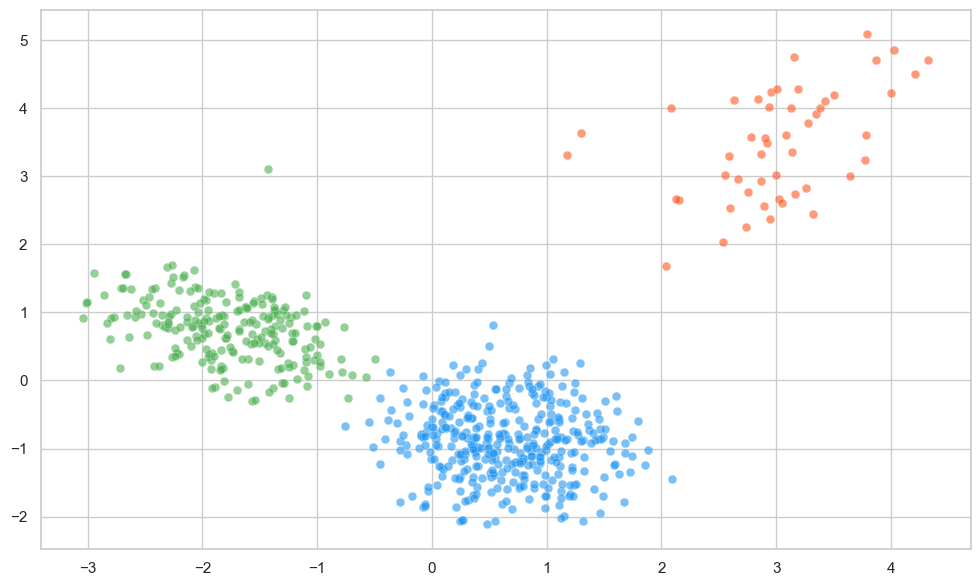

In [44]:
# 6. VISUALIZAÇÕES

# Paleta consistente pra usar em todos os plots
PALETTE = ['#2196F3', '#FF5722', '#4CAF50', '#9C27B0', '#FF9800']

# Reduz pra 2 componentes só pra visualização
pca_2d = PCA(n_components=2)
coords_2d = pca_2d.fit_transform(df_scaled)

df_plot = pd.DataFrame({
    'PC1': coords_2d[:, 0],
    'PC2': coords_2d[:, 1],
    'Cluster': df_clean['Cluster_KMeans'].astype(str),
    'Perfil': df_clean['Perfil']
})

# --- 6.1 Scatter estático ---
fig, ax = plt.subplots(figsize=(12, 7))

for i, (cluster, grupo) in enumerate(df_plot.groupby('Cluster')):
    ax.scatter(
        grupo['PC1'], grupo['PC2'],
        label=nomes_clusters[int(cluster)],
        color=PALETTE[i], alpha=0.6, s=40, edgecolors='white', linewidths=0.3
    )

# Centroides
centroides_2d = pca_2d.transform(
    scaler.transform(
        pd.DataFrame(
            kmeans.cluster_centers_,
            columns=df_clean.columns
        )
    )
)

ax.scatter(
    centroides_2d[:, 0], centroides_2d[:, 1],
    c='black', marker='X', s=200, zorder=5, label='Centróides'
)

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variância)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variância)')
ax.set_title('🗺️ Clusters no Espaço PCA 2D — K-Means', fontsize=15)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

IndexError: list index out of range

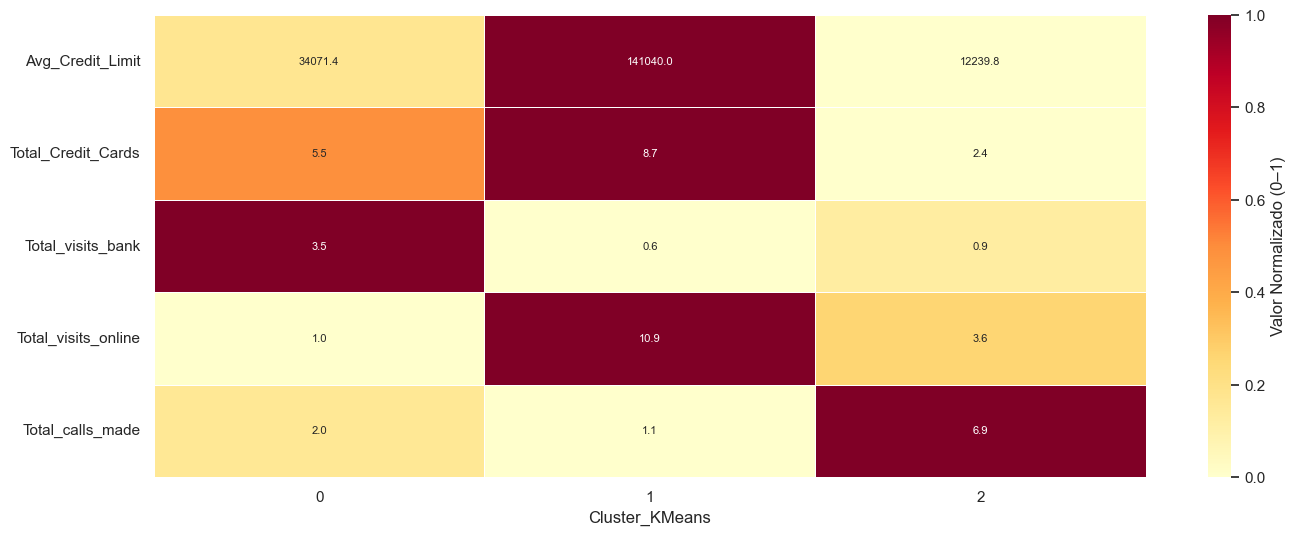

In [45]:
# --- 6.2 Heatmap de perfil médio normalizado ---

# Normaliza o perfil pra comparação visual justa (0 a 1)
from sklearn.preprocessing import MinMaxScaler

perfil_norm = perfil.copy()
mms = MinMaxScaler()
perfil_norm[num_cols] = mms.fit_transform(perfil[num_cols])

plt.figure(figsize=(16, 6))
sns.heatmap(
    perfil_norm.T,
    annot=perfil.T,          # mostra valores originais nas células
    fmt='.1f',
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Valor Normalizado (0–1)'},
    annot_kws={'size': 8}
)

plt.xticks(
    ticks=np.arange(best_k) + 0.5,
    labels=[f'C{i}\n{nomes_clusters[i].split("—")[1].strip()}' for i in range(best_k)],
    rotation=0, fontsize=9
)
plt.title('Heatmap de Perfis — Média por Cluster', fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
# --- 6.4 Tamanho dos clusters ---

contagens = df_clean['Cluster_KMeans'].value_counts().sort_index()
labels_nomes = [nomes_clusters[i].split('—')[1].strip() for i in contagens.index]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barras
bars = axes[0].bar(labels_nomes, contagens.values, color=PALETTE, edgecolor='white', linewidth=1.2)
axes[0].bar_label(bars, labels=[f'{v}\n({v/len(df_clean)*100:.1f}%)' for v in contagens.values],
                  padding=4, fontsize=10)
axes[0].set_title('Distribuição de Clientes por Cluster')
axes[0].set_ylabel('Qtd. Clientes')
axes[0].set_ylim(0, contagens.max() * 1.2)

# Pizza
axes[1].pie(
    contagens.values,
    labels=labels_nomes,
    colors=PALETTE,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(edgecolor='white', linewidth=1.5),
    textprops={'fontsize': 10}
)
axes[1].set_title('Proporção dos Clusters')

plt.suptitle('Tamanho dos Clusters', fontsize=15)
plt.tight_layout()
plt.show()

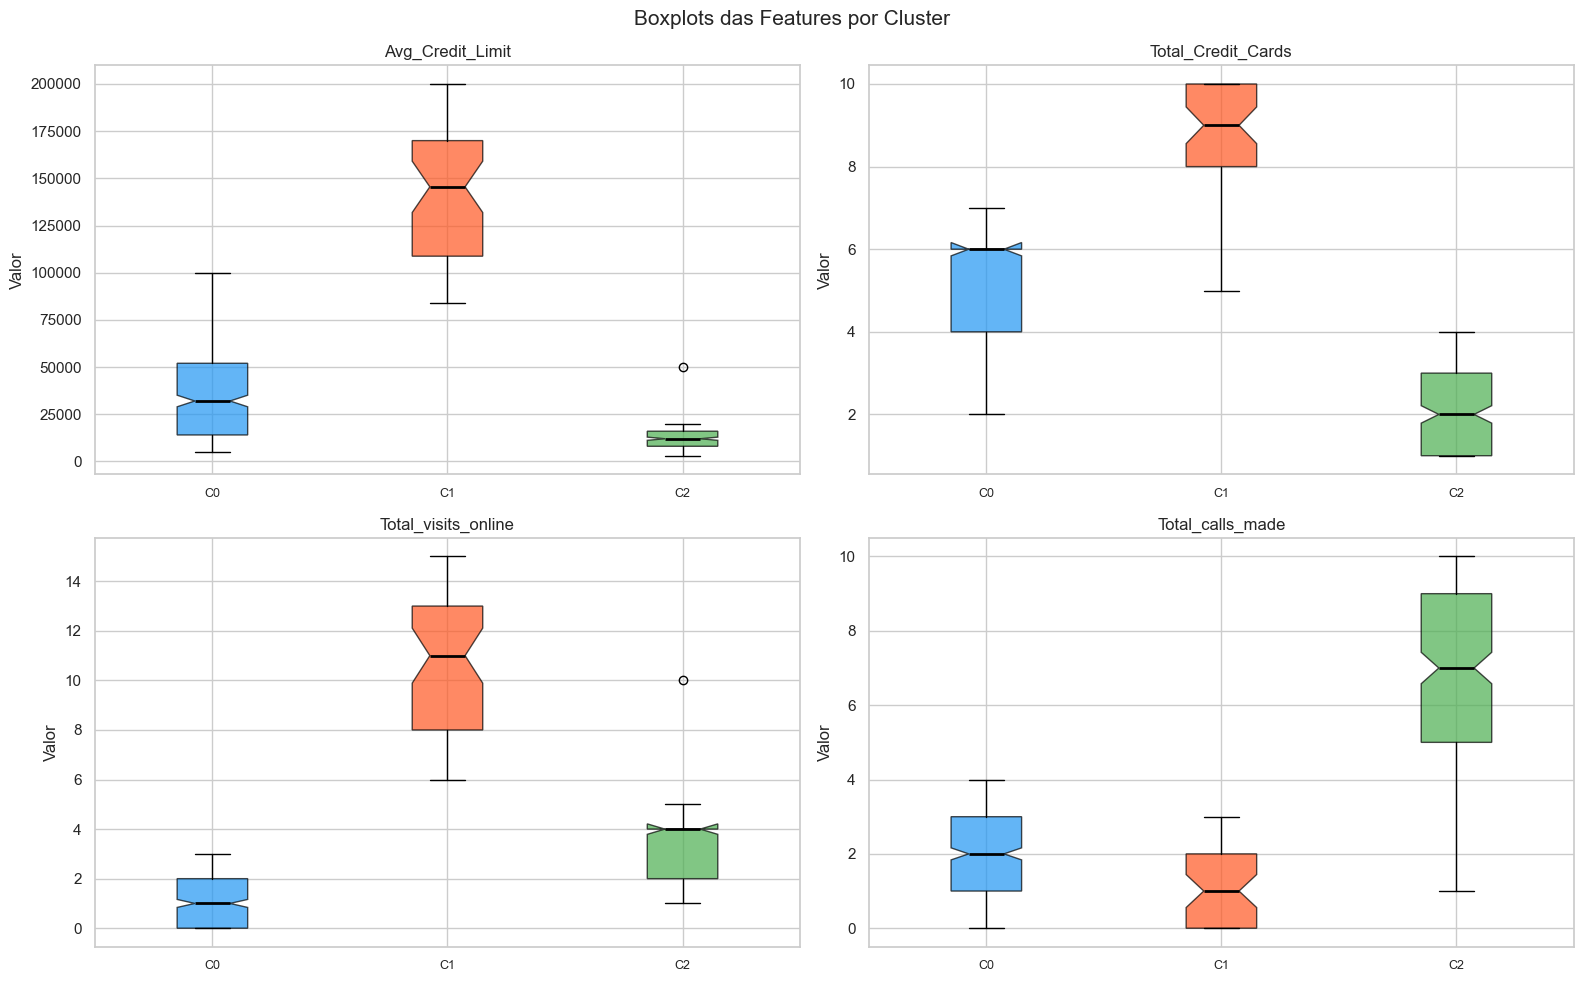

In [47]:
# --- 6.5 Boxplots das principais features por cluster ---

features_box = [
    'Avg_Credit_Limit',
    'Total_Credit_Cards',
    'Total_visits_online',
    'Total_calls_made'
]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(features_box):
    data_by_cluster = [
        df_clean[df_clean['Cluster_KMeans'] == k][col].dropna().values
        for k in range(best_k)
    ]

    bp = axes[i].boxplot(
        data_by_cluster,
        patch_artist=True,
        notch=True,
        medianprops=dict(color='black', linewidth=2)
    )

    for patch, color in zip(bp['boxes'], PALETTE):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[i].set_title(col, fontsize=12)
    axes[i].set_xticklabels(
        [f'C{k}' for k in range(best_k)],
        fontsize=9
    )
    axes[i].set_ylabel('Valor')

plt.suptitle('Boxplots das Features por Cluster', fontsize=15)
plt.tight_layout()
plt.show()

In [50]:
# VALIDAÇÕES ESTATÍSTICAS

from scipy.stats import kruskal, chi2_contingency

alpha = 0.05

# --- 7.1 Kruskal-Wallis ---

print("=" * 60)
print("KRUSKAL-WALLIS — Variáveis Numéricas")
print(f"   H0: os clusters têm a mesma distribuição")
print(f"   H1: ao menos um cluster difere")
print(f"   Nível de significância: {alpha}")
print("=" * 60)

resultados_kw = []

for col in num_cols:
    grupos = [
        df_clean[df_clean['Cluster_KMeans'] == k][col].dropna().values
        for k in range(best_k)
    ]
    stat, p = kruskal(*grupos)
    significativo = 'Sim' if p < alpha else 'Não'

    resultados_kw.append({
        'Feature': col,
        'H-statistic': round(stat, 4),
        'p-value': round(p, 6),
        'Significativo?': significativo
    })

df_kw = pd.DataFrame(resultados_kw).sort_values('p-value')

print(df_kw.to_string(index=False))

KRUSKAL-WALLIS — Variáveis Numéricas
   H0: os clusters têm a mesma distribuição
   H1: ao menos um cluster difere
   Nível de significância: 0.05
            Feature  H-statistic  p-value Significativo?
   Avg_Credit_Limit     259.0805      0.0            Sim
 Total_Credit_Cards     455.0096      0.0            Sim
  Total_visits_bank     429.5047      0.0            Sim
Total_visits_online     444.8181      0.0            Sim
   Total_calls_made     422.2425      0.0            Sim


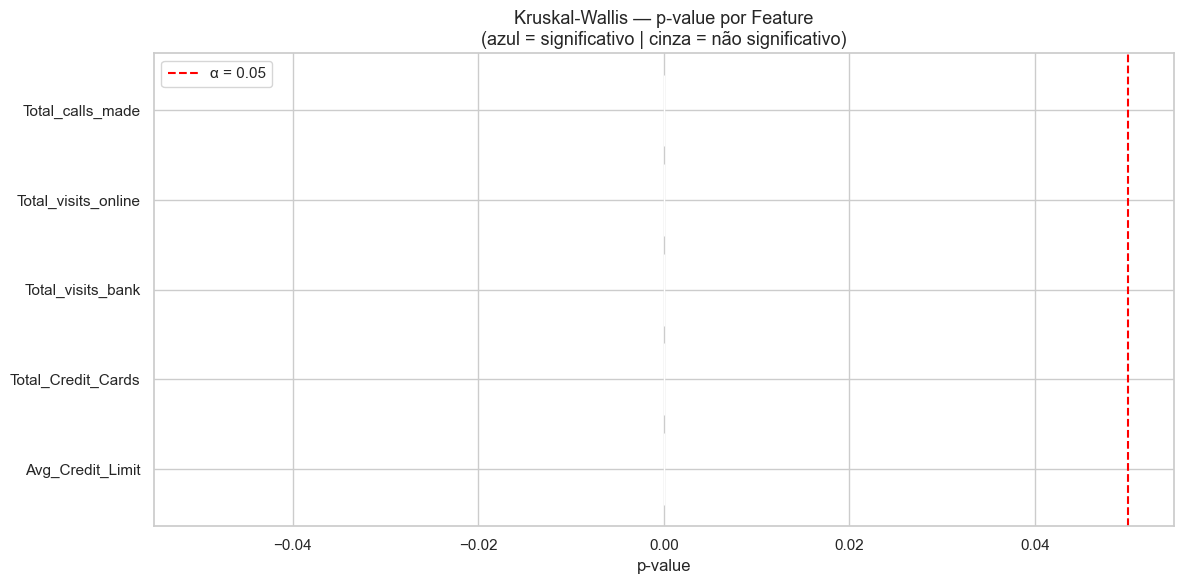


5 de 5 features com diferença significativa entre clusters (p < 0.05)


In [51]:
# Visualização dos p-values
plt.figure(figsize=(12, 6))

colors_bar = [PALETTE[0] if p < alpha else '#BDBDBD' for p in df_kw['p-value']]

bars = plt.barh(df_kw['Feature'], df_kw['p-value'],
                color=colors_bar, edgecolor='white')

plt.axvline(x=alpha, color='red', linestyle='--', linewidth=1.5, label=f'α = {alpha}')
plt.xlabel('p-value')
plt.title('Kruskal-Wallis — p-value por Feature\n(azul = significativo | cinza = não significativo)', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

sig = df_kw[df_kw['p-value'] < alpha].shape[0]
print(f"\n{sig} de {len(num_cols)} features com diferença significativa entre clusters (p < {alpha})")

In [54]:
# --- 7.3 Resumo consolidado ---

print("\n" + "=" * 60)
print("RESUMO DAS VALIDAÇÕES ESTATÍSTICAS")
print("=" * 60)

sig_kw  = df_kw[df_kw['p-value'] < alpha]['Feature'].tolist()
nsig_kw = df_kw[df_kw['p-value'] >= alpha]['Feature'].tolist()

print(f"\nKruskal-Wallis (numéricas):")
print(f"  Significativas : {sig_kw}")
print(f"  Não significat.: {nsig_kw}")

print(f"\nChi-Quadrado (categóricas):")
print(f"   Significativas : {sig_chi}")
print(f"   Não significat.: {nsig_chi}")

print(f"""
Interpretação:
   • Features significativas no Kruskal-Wallis indicam que
     os clusters se comportam de forma estatisticamente
     diferente nessas variáveis — ou seja, a segmentação
     capturou padrões reais de comportamento.

   • Features significativas no Chi² indicam que a
     distribuição das categorias não é aleatória entre
     clusters — reforçando a qualidade da segmentação.
""")


RESUMO DAS VALIDAÇÕES ESTATÍSTICAS

Kruskal-Wallis (numéricas):
  Significativas : ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
  Não significat.: []

Chi-Quadrado (categóricas):


NameError: name 'sig_chi' is not defined